In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 90% !important; }</style>"))

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import isnan, isnull, sum as _sum, when, count, col, avg, isnull, isnan
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import time
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import f1_score
import math
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import DecisionTreeRegressor
from sklearn import tree
import re
from graphviz import Digraph, Source
import matplotlib.colors as mcolors

SEED = 42

In [3]:
spark = SparkSession.builder \
        .appName("Eda") \
        .master("local[*]") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

## Introduction

We are interested into finding out how (**39**) loans default and (**8**) interest rates perform based on the following data:

- (**7**) Original Interest Rate: original interest rate on a mortgage loan is identified in the original mortgage note.
- (**8**) Current Interest Rate: rate of interest in effect for the periodic installment due.
- (**11**) Current Actual UPB: current actual outstanding unpaid principal balance of a mortgage loan, reflective of payments actually received from the related borrower.


- (**15**) Loan Age: number of calendar months since the mortgage loan's origination date. For purposes of calculating this data element, origination means the date on which the first full month of interest begins to accrue.
- (**20**) Original Combined Loan to Value Ratio: ratio, expressed as a percentage, obtained by dividing the amount of all known outstanding loans at origination by the value of the property.
- (**21**) Number of Borrowers: number of individuals obligated to repay the mortgage loan.
- (**22**) Debt-to-income Ratio: ratio obtained by dividing the total monthly debt expense by the total monthly income of the borrower at the time the loan was originated.
- (**23**) Borrow Credit Score at Origination: numerical value used by the financial services industry to evaluate the quality of borrower's credit.
- (**30**) Property State: two-letter abbreviation indicating the state or territory within which the property securing the mortgage loan is located.
- (**31**) Metropolitan Statistical Area: numeric Metropolitan Statistical Area Code for the property securing the mortgage loan.
- (**32**) Zip Code Short: first three digits of the code designated by the U.S. Postal Service where the subject property is located.
- (**41**) Modification Flag: indicator that denotes if the mortgage loan has been modified.

- **A_PCT10**: 10th percentile annual salary

- **A_PCT25**: 25th percentile annual salary

- **A_MEDIAN**: median annual salary

- **A_PCT75**: 75th percentile annual salary

- **A_PCT90**: 90th percentile annual salary

In [4]:
cols_map = \
{
    "7": "Original Interest Rate",
    "8": "Current Interest Rate",
    "11": "Current UPB",
    "15": "Loan Age",
    "20": "Combined LTV Ratio",
    "21": "Number of Borrowers",
    "22": "Debt to Income",
    "23": "Credit Score",
    "30": "State",
    "31": "MSA",
    "32": "Zip Short Code",
    "39": "Delinquency Status",
    "41": "Modification Flag",
}

In [5]:
q1_2022_path = "./data/2022Q1.parquet"
cols = ['7', '8', '11', '15', '20', '21', '22', '23', '30', '31', '32', '41', '39']
q1 = spark.read.parquet(q1_2022_path)
q1 = q1.select(cols)
q1.printSchema()

root
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 20: long (nullable = true)
 |-- 21: long (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 30: string (nullable = true)
 |-- 31: long (nullable = true)
 |-- 32: long (nullable = true)
 |-- 41: string (nullable = true)
 |-- 39: long (nullable = true)



In [6]:
q1.show(3)

+-----+-----+--------+----+---+---+----+-----+---+-----+---+---+---+
|    7|    8|      11|  15| 20| 21|  22|   23| 30|   31| 32| 41| 39|
+-----+-----+--------+----+---+---+----+-----+---+-----+---+---+---+
|3.375|3.375|255000.0|-1.0| 72|  1|43.0|703.0| NV|29820|891|  N|  0|
|3.375|3.375|255000.0| 0.0| 72|  1|43.0|703.0| NV|29820|891|  N|  0|
|3.375|3.375|255000.0| 1.0| 72|  1|43.0|703.0| NV|29820|891|  N|  0|
+-----+-----+--------+----+---+---+----+-----+---+-----+---+---+---+
only showing top 3 rows



In [7]:
msa = spark.read.csv("./data/msa.txt", sep = "\t", header=True)
msa = msa.select(['GEOID', 'INTPTLAT', 'INTPTLONG'])
msa = msa.withColumn("longitude", msa['INTPTLONG'].cast("float"))
msa = msa.withColumn("latitude", msa['INTPTLAT'].cast("float"))
msa = msa.withColumn("31", msa['GEOID'].cast("long"))
msa = msa.select(['31', 'latitude', 'longitude'])
msa.printSchema()

root
 |-- 31: long (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



In [8]:
msa.show(2)

+-----+---------+----------+
|   31| latitude| longitude|
+-----+---------+----------+
|10180|32.452023| -99.71874|
|10300|41.896023|-84.074356|
+-----+---------+----------+
only showing top 2 rows



In [9]:
msa_stats_modified = True

if not msa_stats_modified:
    # This chunk is to preprocess data that will be used with the above.
    msa_stats = pd.read_csv("./data/msa_stats.csv")
    msa_stats['31'] = msa_stats['31'].astype(str)
    
    for col in msa_stats.columns:
        if col != '31':
            # Converts to numeric type and fills in NaN for non-numeric values
            msa_stats[col] = msa_stats[col].str.replace(',', '', regex=False)
            msa_stats[col] = pd.to_numeric(msa_stats[col], errors='coerce')
    
    grouped_means = msa_stats.groupby('31').transform(lambda group: group.fillna(group.mean(numeric_only=True)))
    msa_stats.update(grouped_means)
    msa_stats = msa_stats.groupby('31').mean().reset_index()
    msa_stats.to_csv("./data/msa_stats.csv", index_label=False)

rounded = True

if not rounded:
    msa_stats = pd.read_csv("./data/msa_stats.csv")

    for col in msa_stats.columns:
        if col != '31' or col != 'GEOID':
            msa_stats[col] = msa_stats[col].round(0).astype(int)

    msa_stats.to_csv("./data/msa_stats.csv", index_label=True)

In [10]:
msa_stats = spark.read.csv("./data/msa_stats.csv", header=True, inferSchema=True)
msa_stats = msa_stats.withColumn("31", msa_stats['GEOID'].cast("long"))
msa_stats = msa_stats.drop('GEOID')
msa_stats = msa_stats.drop('True')

msa = msa.join(msa_stats, on="31", how="left")
msa.printSchema()

root
 |-- 31: long (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- A_PCT10: integer (nullable = true)
 |-- A_PCT25: integer (nullable = true)
 |-- A_MEDIAN: integer (nullable = true)
 |-- A_PCT75: integer (nullable = true)
 |-- A_PCT90: integer (nullable = true)



In [11]:
msa.show(2)

+-----+---------+----------+-------+-------+--------+-------+-------+
|   31| latitude| longitude|A_PCT10|A_PCT25|A_MEDIAN|A_PCT75|A_PCT90|
+-----+---------+----------+-------+-------+--------+-------+-------+
|10180|32.452023| -99.71874|  32433|  39149|   48158|  59148|  72551|
|10300|41.896023|-84.074356|   NULL|   NULL|    NULL|   NULL|   NULL|
+-----+---------+----------+-------+-------+--------+-------+-------+
only showing top 2 rows



In [12]:
n_rows = q1.count()
n_cols = len(q1.columns)
print(f"Shape: ({n_rows}, {n_cols})")

Shape: (24335718, 13)


In [13]:
null_nan_counts = q1.select([
    _sum((isnull(col(c)) | isnan(col(c))).cast("int")).alias(c) for c in cols
])

null_counts_pd = null_nan_counts.toPandas()

In [14]:
null_counts_pd = null_counts_pd.T
null_counts_pd.columns = ["null_count"]
null_counts_pd.index.name = "column"

null_counts_pd['null_count'] = null_counts_pd.iloc[:, 0] / n_rows * 100
exc_null = null_counts_pd.loc[null_counts_pd.iloc[:, 0] > 20, :]

In [15]:
print("Cols to Exlucde (Those with > 20% Null):\n", exc_null.index)

Cols to Exlucde (Those with > 20% Null):
 Index([], dtype='object', name='column')


In [16]:
print("Null % for Remaining Columns:\n", null_counts_pd.loc[null_counts_pd.iloc[:, 0] <= 20, :])

Null % for Remaining Columns:
         null_count
column            
7         0.000000
8         0.320348
11        0.000000
15        0.321347
20        0.000000
21        0.000000
22        0.011847
23        0.051899
30        0.000000
31        0.000000
32        0.000136
41        0.320410
39        0.000000


For our interest, we can see that the percentage is missing data is extremely small, with the highest missing percentage at 0.32 %. To determine what to do with our missing data, we will first find the % of null by each state and see whether these are somewhat uniformly distributed among each state.

In [17]:
null_15 = q1.select(cols).filter(col('15').isNull() | col('41').isNull())
print(f"# of Missing Rows: {null_15.count()}")

# of Missing Rows: 78202


In [18]:
grouped_null = null_15.groupBy("30").count().orderBy(col("count").desc()).toPandas()
grouped_null.set_index("30", inplace=True)

grouped_counts = q1.select("30").groupBy("30").count().orderBy(col("count").desc()).toPandas()
grouped_counts.set_index("30", inplace=True)

In [19]:
pct_null = (grouped_null / grouped_counts).sort_values(by="count")
print("% Null by State")
print(f"Mean: {pct_null['count'].mean():.4f}, Std: {pct_null['count'].std():.4f}")

space = 9
for i in range(pct_null.shape[0]):
    if (space % 9) == 0:
        print()

    state = pct_null.index[i]
    pct = pct_null['count'][i]
    print(f"{state}  {pct:.4f}\t", end='')
    space -= 1

% Null by State
Mean: 0.0033, Std: 0.0007

GU  0.0014	PR  0.0018	DC  0.0018	NY  0.0018	CA  0.0023	MD  0.0024	HI  0.0024	VI  0.0024	MA  0.0025	
DE  0.0025	NJ  0.0026	PA  0.0026	CT  0.0028	MN  0.0028	OR  0.0029	WA  0.0029	LA  0.0030	IL  0.0030	
ND  0.0030	VA  0.0031	UT  0.0031	RI  0.0032	WI  0.0032	CO  0.0033	TX  0.0034	NV  0.0034	MI  0.0034	
IA  0.0034	NM  0.0034	WV  0.0034	OH  0.0035	ME  0.0035	NE  0.0036	AZ  0.0036	MT  0.0037	ID  0.0037	
NH  0.0038	OK  0.0038	AK  0.0038	VT  0.0039	NC  0.0039	MO  0.0039	SD  0.0039	GA  0.0040	KY  0.0040	
IN  0.0040	FL  0.0041	MS  0.0041	KS  0.0042	SC  0.0043	TN  0.0043	AL  0.0044	AR  0.0045	WY  0.0046	

By the above, we see that the % of missing values can be described as uniformly spread over the different states. Thus, it can be deemed safe to drop these observations as they will not affect our analysis of the features on default status.

In [20]:
before_rows = q1.count()
print(f"Before dropping NA: {q1.count()} rows")

q1 = q1.dropna()
print(f"After dropping NA: {q1.count()} rows")

print(f"% of rows dropped: {1 - (q1.count() / before_rows)}")

Before dropping NA: 24335718 rows
After dropping NA: 24242027 rows
% of rows dropped: 0.0038499377745911945


In [21]:
def check_NA(rdd):
    null_nan_counts = rdd.select([
        _sum((isnull(col(c)) | isnan(col(c))).cast("int")).alias(c) for c in rdd.columns
    ])
    
    null_counts_pd = null_nan_counts.toPandas()
    print(null_counts_pd)

check_NA(q1)

   7  8  11  15  20  21  22  23  30  31  32  41  39
0  0  0   0   0   0   0   0   0   0   0   0   0   0


## EDA

Now that we have taken care of the missing data, we will go ahead and dive further into exploring out the data.


1. How are mortgage loans considered to be on default?

    By the definition provided by several sources, if payments are overdue by 30 days, it is considered in default.

In [22]:
# Register the data as 'loans' for SQL exploration
q1.createOrReplaceTempView("loans")
msa_stats.createOrReplaceTempView("stats")

In [23]:
q1 = q1.withColumn("Defaulted", (q1["39"] > 1).cast("int"))
q1 = q1.withColumn("41", (q1["41"] == 'Y').cast("int"))
# q1 = q1.join(msa, on="31", how="left")

In [24]:
q1.printSchema()

root
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 20: long (nullable = true)
 |-- 21: long (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 30: string (nullable = true)
 |-- 31: long (nullable = true)
 |-- 32: long (nullable = true)
 |-- 41: integer (nullable = true)
 |-- 39: long (nullable = true)
 |-- Defaulted: integer (nullable = true)



In [25]:
check_NA(q1)

   7  8  11  15  20  21  22  23  30  31  32  41  39  Defaulted
0  0  0   0   0   0   0   0   0   0   0   0   0   0          0


In [26]:
## Let's see the percentage of defaults per state and MSA codes

default_state = \
spark.sql( \
    """
    WITH pct_default AS (
    SELECT `30` AS STATE, `31` AS MSA, ROUND(AVG(`39`)*100, 2) AS PCT_DEFAULT 
    FROM loans
    GROUP BY `30`, `31`
    ORDER BY PCT_DEFAULT DESC
    )

    SELECT STATE, MSA, PCT_DEFAULT, A_PCT10, A_PCT25, A_MEDIAN, A_PCT75, A_PCT90
    FROM pct_default l LEFT JOIN stats s ON l.MSA = s.`31`
    ORDER BY PCT_DEFAULT DESC
    """)

default_state.show(20)

+-----+-----+-----------+-------+-------+--------+-------+-------+
|STATE|  MSA|PCT_DEFAULT|A_PCT10|A_PCT25|A_MEDIAN|A_PCT75|A_PCT90|
+-----+-----+-----------+-------+-------+--------+-------+-------+
|   MA|38340|       10.9|   NULL|   NULL|    NULL|   NULL|   NULL|
|   IN|29020|      10.41|  34807|  41307|   50546|  62184|  75346|
|   AR|32820|      10.05|  36584|  44115|   53774|  66182|  80909|
|   FL|39460|       9.44|  35280|  41886|   52211|  63545|  75429|
|   MT|24500|        9.2|  34080|  39817|   48450|  58579|  68787|
|   ME|30340|       9.16|   NULL|   NULL|    NULL|   NULL|   NULL|
|   AL|19460|       9.03|  35605|  42869|   52023|  64393|  77637|
|   KY|21060|       8.98|  35282|  41818|   51717|  61999|  72835|
|   OK|22900|       8.43|  31528|  37818|   46465|  56899|  68898|
|   LA|29340|       8.24|  34276|  41161|   51601|  64042|  78874|
|   HI|27980|        8.0|  41832|  49747|   61194|  75340|  90525|
|   FL|15980|       7.93|  37848|  44032|   53747|  66839|  82

In [27]:
spark.sql( \
    """
    WITH pct_default AS (
    SELECT `30` AS STATE, `31` AS MSA, ROUND(AVG(`39`)*100, 2) AS PCT_DEFAULT 
    FROM loans
    GROUP BY `30`, `31`
    ORDER BY PCT_DEFAULT DESC
    )

    SELECT STATE, MSA, PCT_DEFAULT, A_PCT10, A_PCT25, A_MEDIAN, A_PCT75, A_PCT90
    FROM pct_default l LEFT JOIN stats s ON l.MSA = s.`31`
    ORDER BY PCT_DEFAULT
    LIMIT 20
    """).show()

+-----+-----+-----------+-------+-------+--------+-------+-------+
|STATE|  MSA|PCT_DEFAULT|A_PCT10|A_PCT25|A_MEDIAN|A_PCT75|A_PCT90|
+-----+-----+-----------+-------+-------+--------+-------+-------+
|   PR|49500|        0.0|   NULL|   NULL|    NULL|   NULL|   NULL|
|   PR|25020|        0.0|  21738|  25462|   29734|  37558|  47937|
|   KS|41140|        0.0|  36756|  43283|   53046|  65654|  79312|
|   IL|16020|        0.0|  33700|  41082|   48763|  61561|  73678|
|   PR|38660|        0.1|  22049|  25299|   30855|  37678|  48586|
|   ND|24220|       0.11|  39580|  46211|   55396|  66248|  80095|
|   MN|29100|       0.14|  41288|  47560|   57386|  68610|  81010|
|   WA|30300|       0.15|  37775|  45394|   53661|  64924|  77935|
|   WI|20260|       0.19|  41766|  49097|   57344|  69585|  81663|
|   GA|25980|        0.2|  32674|  39549|   49218|  61531|  74253|
|   PR|32420|        0.2|  20423|  23086|   28321|  36545|  46122|
|   AL|20020|       0.29|  29872|  36257|   45004|  55980|  65

## State / Island % Default on Boxplot

In [28]:
default_state_df = default_state.toPandas()
default_state = default_state.withColumn("31", default_state["MSA"].cast("long"))
msa = msa.join(default_state.select(["31", "PCT_DEFAULT"]), on="31", how='left')

In [29]:
def aggregate(df):
    out = {'PCT_DEFAULT': df['PCT_DEFAULT'].values}
    return pd.Series(out)

state_default = default_state_df.groupby("STATE").apply(aggregate)

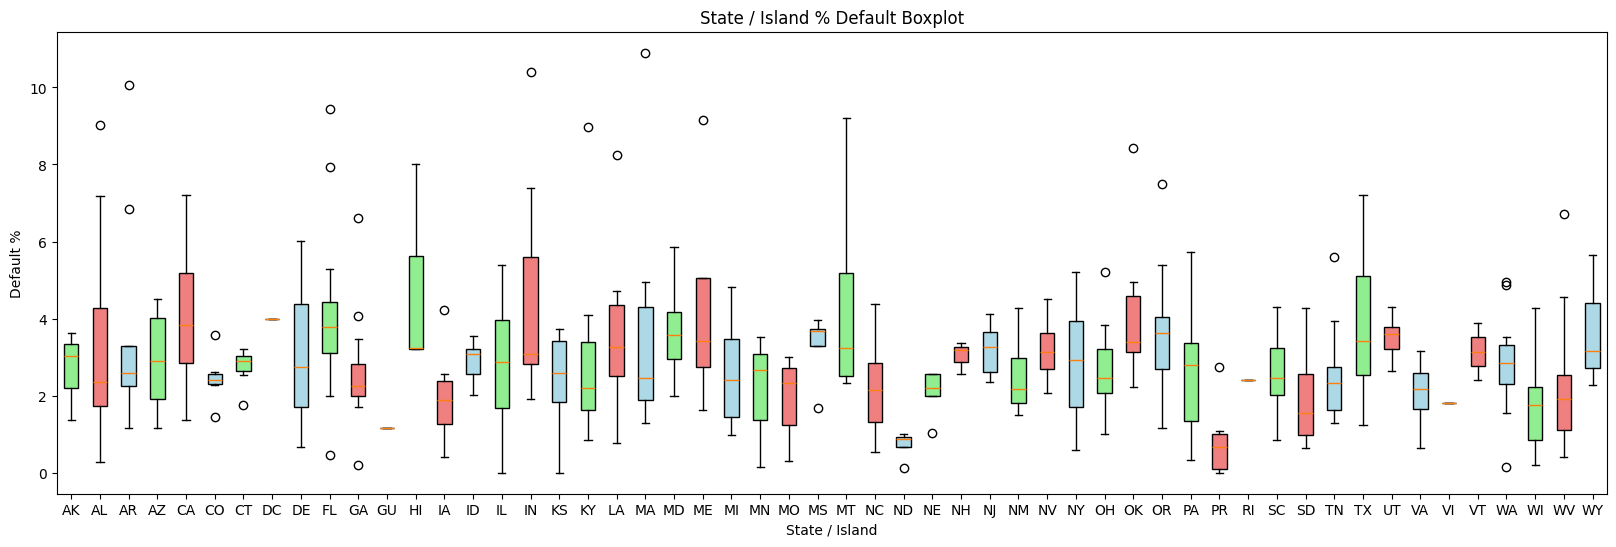

In [30]:
colors = (['lightgreen', 'lightcoral', 'lightblue'] * (state_default.shape[0] // 2))[:state_default.shape[0]]

fig, ax = plt.subplots(figsize=(20, 6))
bp = ax.boxplot(state_default.values[:, 0], patch_artist=True, labels=state_default.index)
ax.set_title("State / Island % Default Boxplot")
ax.set_ylabel("Default %")
ax.set_xlabel("State / Island")

# Iterate through boxes and apply colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

The above shows the top and bottom 20 metropolitan areas with the default rates (in %), as well as the boxplots of all states and islands.

Now let's take a look into correlation of the states have MSA with high default rates and have a sufficient amount of data (by looking at the bar size).

In [31]:
spark.sql(
    """
    SELECT `31`, `30`, SUM(`39`) AS DEFAULT_COUNT, COUNT(*) AS TOTAL_COUNT, ROUND(DEFAULT_COUNT / TOTAL_COUNT, 2) AS DEFAULT_PCT
    FROM loans
    GROUP BY `30`, `31`
    HAVING `30` == 'IL'
    ORDER BY DEFAULT_PCT DESC
    """
).show()

+-----+---+-------------+-----------+-----------+
|   31| 30|DEFAULT_COUNT|TOTAL_COUNT|DEFAULT_PCT|
+-----+---+-------------+-----------+-----------+
|19500| IL|          233|       4314|       0.05|
|40420| IL|         1029|      21353|       0.05|
|19180| IL|          114|       2312|       0.05|
|28100| IL|          216|       5300|       0.04|
|16980| IL|        22341|     622682|       0.04|
|    0| IL|         1545|      44574|       0.03|
|44100| IL|          454|      14058|       0.03|
|41180| IL|          944|      37713|       0.03|
|16580| IL|          154|       9229|       0.02|
|37900| IL|          346|      15384|       0.02|
|16060| IL|           85|       4921|       0.02|
|19340| IL|          130|      10064|       0.01|
|14010| IL|          111|       9499|       0.01|
|16020| IL|            0|         63|        0.0|
+-----+---+-------------+-----------+-----------+



## Correlation Heatmap

Selected based on default percentage and curiosity:
- IN, 29020
- KY, 21060
- AR, 32820
- MA, 14460
- CA, 41940

In [32]:
corr_results = {}
# states = pct_null.index
states_msa = [('IN', 29020), ('KY', 21060), ('AR', 32820), ('MA', 14460), ('CA', 41940)]

In [33]:
%%time

to_skip = ["30", "31", "32", "41"]
inputCols = [col for col in q1.columns if col not in to_skip]

for state, msa_code in tqdm(states_msa):
    tmp_q1 = q1.filter((col("30") == state))
    
    assembler = VectorAssembler(inputCols = inputCols, outputCol = "features")
    vector_df = assembler.transform(tmp_q1).select("features")
    corr_matrix = Correlation.corr(vector_df, "features", method="pearson").collect()[0][0]

    corr_df_state = pd.DataFrame(corr_matrix.toArray(), index=inputCols, columns=inputCols)

    tmp_q1 = q1.filter((col("30") == state) & (col("31") == msa_code))
    
    assembler = VectorAssembler(inputCols = inputCols, outputCol = "features")
    vector_df = assembler.transform(tmp_q1).select("features")
    corr_matrix = Correlation.corr(vector_df, "features", method="pearson").collect()[0][0]

    corr_df_msa = pd.DataFrame(corr_matrix.toArray(), index=inputCols, columns=inputCols)
    corr_results[state] = [msa_code, corr_df_state, corr_df_msa]

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 93.8 ms
Wall time: 49 s


In [34]:
for key, value in corr_results.items():
    value[1].rename(index=cols_map, columns=cols_map, inplace=True)
    value[2].rename(index=cols_map, columns=cols_map, inplace=True)

In [35]:
def plot_correlation_pairs(corr_dict):
    sns.set(style="white", font_scale=0.9)
    
    num_states = len(corr_dict)
    num_cols = 2  # Two plots per row
    num_rows = math.ceil(num_states)

    fig, axes = plt.subplots(num_states, num_cols, figsize=(14, 7 * num_states))
    
    # Ensure axes is 2D (even if there's only one row)
    if num_states == 1:
        axes = [axes]

    for i, (key, (msa_code, corr1, corr2)) in enumerate(corr_dict.items()):
        row = i
        
        sns.heatmap(corr1, ax=axes[row][0], cmap="coolwarm", annot=True, fmt=".2f", square=True, center=0)
        axes[row][0].set_title(f"Overall {key}")

        sns.heatmap(corr2, ax=axes[row][1], cmap="coolwarm", annot=True, fmt=".2f", square=True, center=0)
        axes[row][1].set_title(f"{key}, {msa_code}")
    
    plt.tight_layout()
    plt.show()

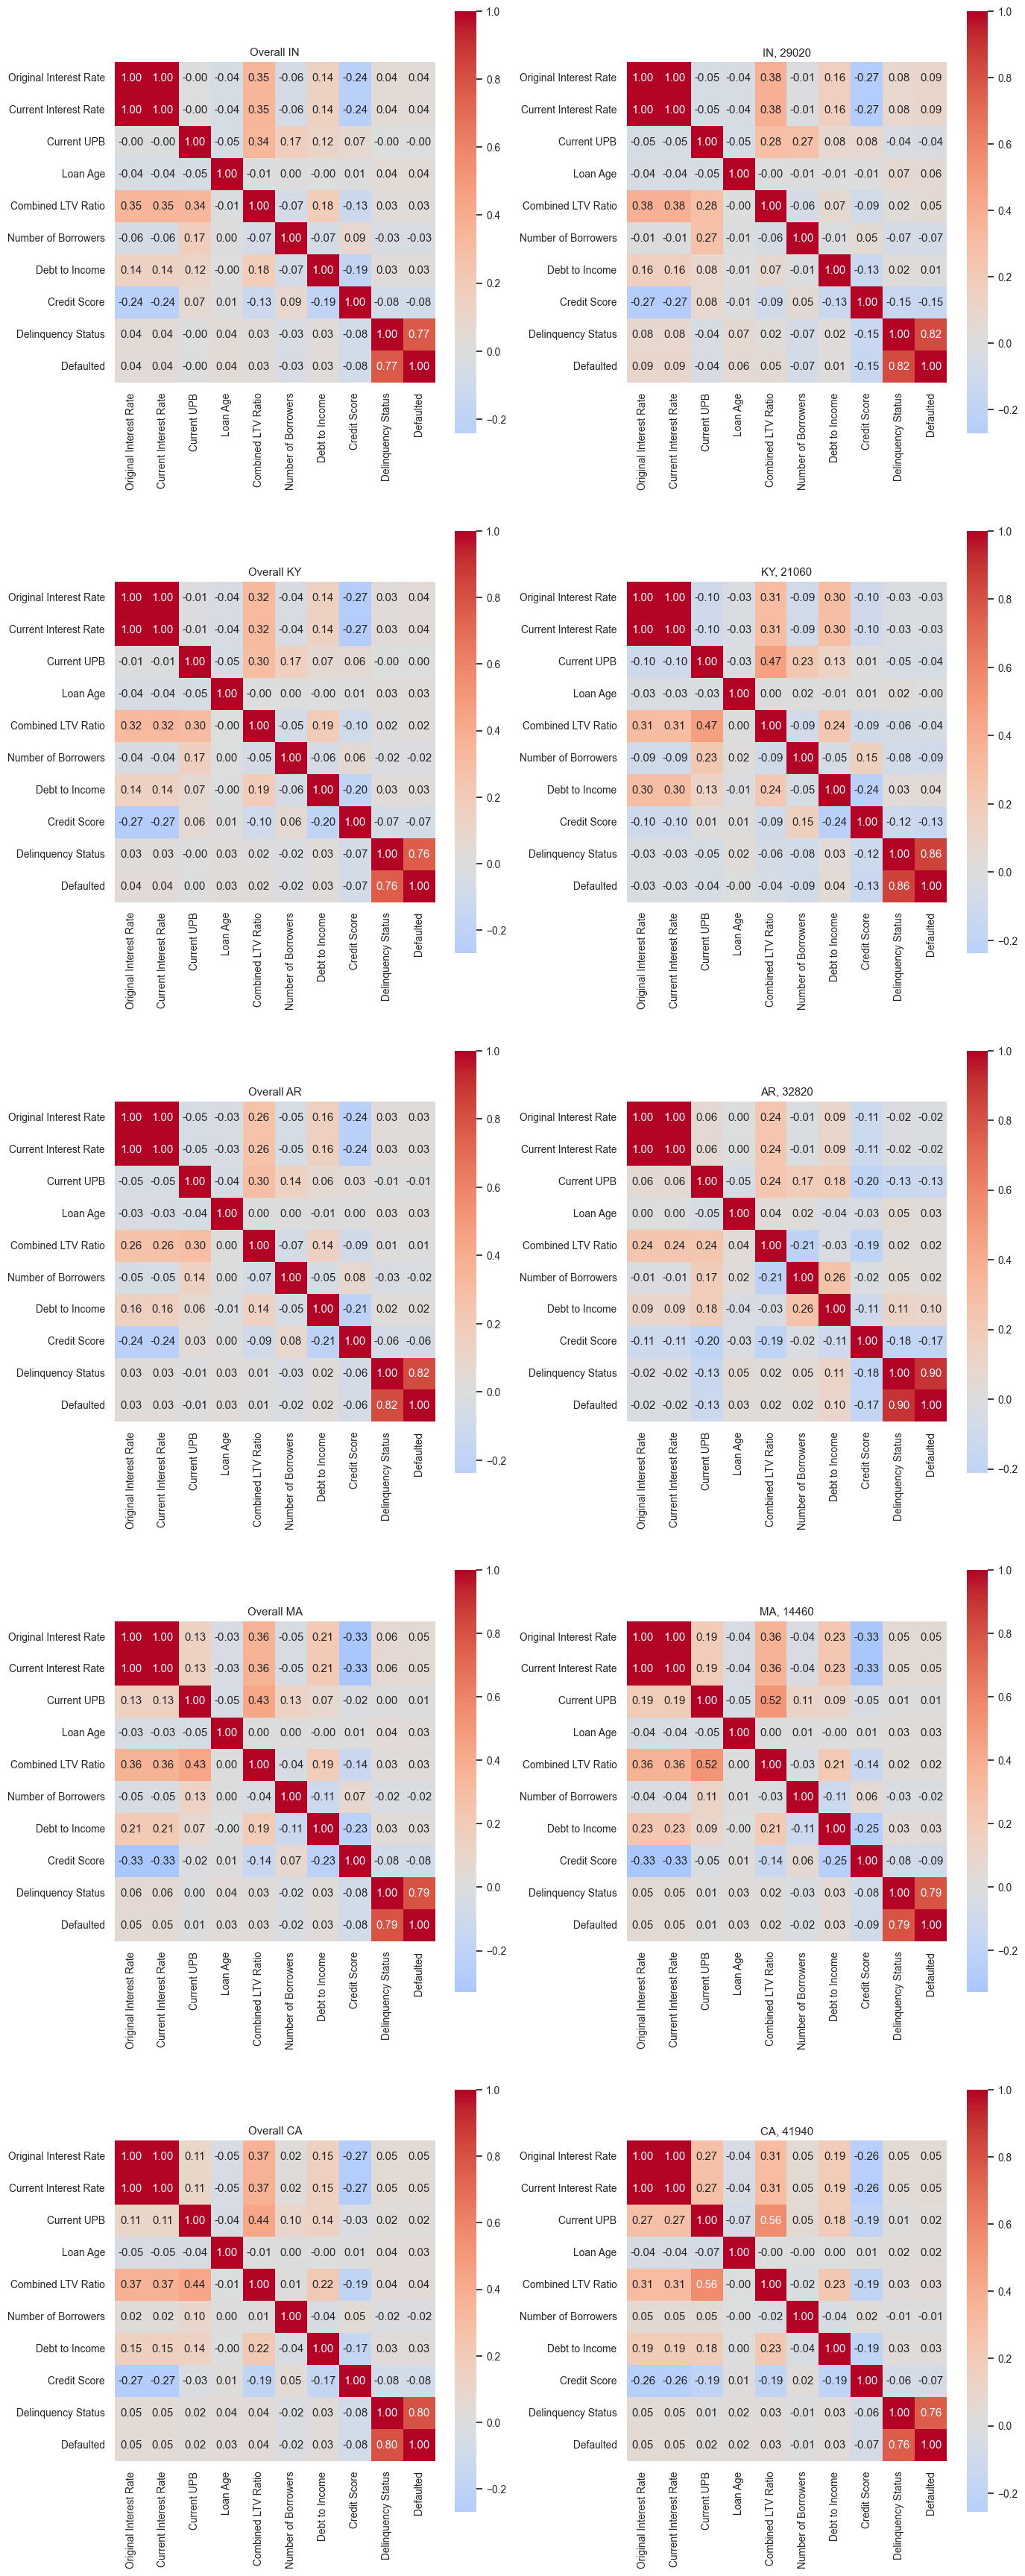

In [36]:
plot_correlation_pairs(corr_results)

From the correlation heatmaps above, features aren't highly linearly correlated with the delinquency status. However, if we compare the overall state performance with a MSA area with high default rate, we can see that factors, such as credit scores, loan age, number of borrowers and current UPB, seem to have relatively higher correlation.

Regardless of how correlations increase, the numbers suggest that we should utilize a non-linear methods to find the relationship of delinquency status and other features.

## Decision Tree by Leveraging PySpark ML

In [37]:
%%time

feature_cols = ['11', '15', '20', '21', '22', '23', '41']
tree_models = {} # state: [state_model, msa_model]
assembler = VectorAssembler(inputCols = feature_cols, outputCol = "features")

for state, msa_code in tqdm(states_msa):
    # state-wide model
    q1_state_model = assembler.transform(q1.filter((col("30") == state)))
    
    # train_state, _ = q1_state_model.randomSplit([0.95, 0.05], seed=SEED)
    dt_state = DecisionTreeRegressor(featuresCol = "features", labelCol= "7", maxDepth=4)
    dt_state_model = dt_state.fit(q1_state_model)

    # msa model
    q1_msa_model = assembler.transform(q1.filter((col("30") == state) & (col("31") == msa_code)))

    # train_msa, _ = q1_msa_model.randomSplit([0.95, 0.05], seed=SEED)
    dt_msa = DecisionTreeRegressor(featuresCol = "features", labelCol= "7", maxDepth=4)
    dt_msa_model = dt_msa.fit(q1_msa_model)

    tree_models[state] = [dt_state_model, dt_msa_model]    

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 62.5 ms
Wall time: 50.3 s


In [38]:
def parse_debug_string(debug_str):
    lines = debug_str.strip().split('\n')
    nodes = {}
    edges = []
    id_counter = 0
    stack = []

    for line in lines[1:]:  # Skip the first line "DecisionTreeClassificationModel..."
        indent = len(line) - len(line.lstrip())
        content = line.strip()
        
        # Create a node ID
        node_id = id_counter
        id_counter += 1
        
        label = content
        nodes[node_id] = label

        while stack and stack[-1][0] >= indent:
            stack.pop()
        
        if stack:
            parent_id = stack[-1][1]
            edges.append((parent_id, node_id))
        
        stack.append((indent, node_id))
    
    return nodes, edges
    
def parse_debug_string_with_conditions(debug_str):
    lines = debug_str.strip().split('\n')
    nodes = {}
    edges = []
    id_counter = 0
    stack = []

    for line in lines[1:]:  # Skip model description line
        indent = len(line) - len(line.lstrip())
        content = line.strip()
        
        node_id = id_counter
        id_counter += 1

        label = content
        nodes[node_id] = label

        while stack and stack[-1][0] >= indent:
            stack.pop()

        if stack:
            parent_indent, parent_id, child_count = stack[-1]
            # Determine if it's a left or right child
            edge_label = "Yes" if child_count == 0 else "No"
            edges.append((parent_id, node_id, edge_label))
            stack[-1] = (parent_indent, parent_id, child_count + 1)

        stack.append((indent, node_id, 0))

    return nodes, edges
    
def render_tree(debug_str, filename='tree', view=True):
    nodes, edges = parse_debug_string(debug_str)
    dot = Digraph(format='png')
    for nid, label in nodes.items():
        dot.node(str(nid), label)

    for src, dst in edges:
        dot.edge(str(src), str(dst))

    dot.render(filename, view=view)

def render_tree_inline(debug_str, index_to_name=None):
    if index_to_name:
        debug_str = replace_feature_names(debug_str, index_to_name)

    nodes, edges = parse_debug_string_with_conditions(debug_str)
    dot = Digraph()
    for nid, label in nodes.items():
        dot.node(str(nid), label)
    for src, dst, label in edges:
        dot.edge(str(src), str(dst), label=label)

    return Source(dot.source)

def render_tree_svg(debug_str, index_to_name=None):
    """
    Render a PySpark tree and return raw SVG string for inline HTML use.
    """
    if index_to_name:
        debug_str = replace_feature_names(debug_str, index_to_name)

    nodes, edges = parse_debug_string_with_conditions(debug_str)
    dot = Digraph(format='svg')
    for nid, label in nodes.items():
        dot.node(str(nid), label)
    for src, dst, label in edges:
        dot.edge(str(src), str(dst), label=label)

    return dot.pipe().decode("utf-8")

def replace_feature_names(debug_str, index_to_name):
    def replacer(match):
        idx = int(match.group(1))
        return f'feature "{index_to_name.get(idx, f"unknown_{idx}")}"'

    return re.sub(r'feature (\d+)', replacer, debug_str)

def display_state_msa_tree_pairs(tree_models, feature_cols):
    """
    Display state and MSA decision trees side by side per state row.
    """
    html_rows = []
    index_to_name = {i: name for i, name in enumerate(feature_cols)}

    for state, (state_model, msa_model) in tree_models.items():
        state_svg = render_tree_svg(state_model.toDebugString, index_to_name)
        msa_svg = render_tree_svg(msa_model.toDebugString, index_to_name)

        row_html = f"""
        <tr>
            <td style='vertical-align:top; padding:10px'>
                <b>{state} - State Tree</b><br>{state_svg}
            </td>
            <td style='vertical-align:top; padding:10px'>
                <b>{state} - MSA Tree</b><br>{msa_svg}
            </td>
        </tr>
        """
        html_rows.append(row_html)

    html = f"<table>{''.join(html_rows)}</table>"
    display(HTML(html))

In [39]:
display_state_msa_tree_pairs(tree_models, feature_cols)

From the splits generated above, the most influencing factors that determine the interest rate of a mortgage are:

- (**20**) Original Combined Loan to Value Ratio
- (**22**) Debt to Income

- (**23**) Borrower Credit Score at Origination

Besides these 3 features, for some specific metropolitan areas (CA, 41940), (**11**) Current Actual UPB played an important role into binning the interest rates.

Contrary to our initial hypothesis on how mortgage loans can also depend on loan age, actual UPB and whether a loan has been modified, we find that loans mostly depend on specific areas and the features mentioned above.

## Default % and Current Interest Rate by MSA

We plot the loan performances on an interactive plot with parameters of interest (Interest Rate, Default Percentage, Defaulted)

In [40]:
def plot_map(data, msa, states=[], file_name="map.html", size=500000):
    if states:
        tmp = q1.select(["31", "8", "Defaulted"]).filter((col("30").isin(states)) & (col("31") != 0))
    else:
        tmp = q1.select(["31", "8", "Defaulted"]).filter((col("31") != 0))

    count = tmp.count()

    if size:
        fraction = round(size/count, 4)
    else:
        fraction = 1
    
    tmp = tmp.sample(fraction=fraction, seed=SEED)
    tmp = tmp.join(msa, on="31", how="left").select(["8", "latitude", "longitude", "Defaulted", "PCT_DEFAULT"])
    df = tmp.toPandas()
    
    # Drop missing values and keep required columns
    df = df[['latitude', 'longitude', 'Defaulted', '8', 'PCT_DEFAULT']].dropna()
    
    # Normalize column "8" to control opacity between 0 and 1
    norm = mcolors.Normalize(vmin=df["8"].min(), vmax=df["8"].max())
    df["opacity"] = df["8"].apply(lambda x: norm(x))

    # Set color based on Defaulted
    def get_color(val):
        return 'red' if val == 1 else 'blue'
    
    # Create folium map
    m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=5)
    marker_cluster = MarkerCluster().add_to(m)
    
    # Add CircleMarkers
    for _, row in tqdm(df.iterrows()):
        popup_text = f"""
            Defaulted: {row['Defaulted']}<br>
            MSA Default %: {round(row['PCT_DEFAULT'], 2)}<br>
            Current Interest Rate: {row['8']}
        """
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=6,
            popup=folium.Popup(popup_text, max_width=300),
            color=get_color(row['Defaulted']),
            fill=True,
            fill_color=get_color(row['Defaulted']),
            fill_opacity=row["opacity"]
        ).add_to(marker_cluster)
    
    # Save or display
    m.save("map.html")

In [41]:
# %%time
# plot_map(q1, msa, size=100000)